In [0]:
import pandas as pd
import numpy as np
import csv

%tensorflow_version 2.x
import tensorflow as tf
tf.__version__
assert tf.__version__ >= "2.0"

from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
x_train = pd.read_csv('/content/drive/My Drive/bilstm_data/x_train.csv')
x_test = pd.read_csv('/content/drive/My Drive/bilstm_data/x_test.csv')
x_val = pd.read_csv('/content/drive/My Drive/bilstm_data/x_val.csv')


y_train = pd.read_csv('/content/drive/My Drive/bilstm_data/y_train.csv')
y_test = pd.read_csv('/content/drive/My Drive/bilstm_data/y_test.csv')
y_val = pd.read_csv('/content/drive/My Drive/bilstm_data/y_val.csv')


In [0]:
texts = x_train['article_text'].values
texts_test = x_test['article_text'].values

In [0]:
texts_val = x_val['article_text'].values
labels_val = y_val['label'].values

In [0]:
labels_test = y_test['label'].values
labels = y_train['label'].values

In [0]:
print(labels.shape, labels_test.shape, labels_test.shape)

(5746,) (3429,) (3429,)


In [0]:
len(y_test.loc[y_test['label']==0])

3076

In [0]:
len(y_test.loc[y_test['label']==1])

353

In [0]:
MAX_NUM_WORDS = 3000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 128 # max number of words in a review to use


In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_train = Tokenizer(num_words=MAX_NUM_WORDS) #convert word(string to int)
tokenizer_train.fit_on_texts(texts) 
sequences = tokenizer_train.texts_to_sequences(texts) 

word_index = tokenizer_train.word_index #convert this to dict
print('Found %s unique tokens.' % len(word_index))


Found 85423 unique tokens.


In [0]:
sequences3 = tokenizer_train.texts_to_sequences(texts_val) 
sequences_test = tokenizer_train.texts_to_sequences(texts_test)

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (5746, 128)
Shape of label tensor: (5746, 2)


In [0]:
data2 = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
labels2 = to_categorical(np.asarray(labels_test))
print('Shape of data tensor:', data2.shape)
print('Shape of label tensor:', labels2.shape)

data3 = pad_sequences(sequences3, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
labels3 = to_categorical(np.asarray(labels_val))
print('Shape of data tensor:', data3.shape)
print('Shape of label tensor:', labels3.shape)


Shape of data tensor: (3429, 128)
Shape of label tensor: (3429, 2)
Shape of data tensor: (639, 128)
Shape of label tensor: (639, 2)


In [0]:
x_train = data
y_train = labels

x_val = data3
y_val = labels3

x_test = data2
y_test = labels2

In [0]:
print(y_train.shape, y_val.shape, y_test.shape)

(5746, 2) (639, 2) (3429, 2)


In [0]:
GLOVE_DIR='drive/My Drive/yelp_review_polarity_csv/'

import os
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 1917494 word vectors.


In [0]:
EMBEDDING_DIM = 300 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, TimeDistributed, Flatten,RepeatVector, Permute, Multiply, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import sum

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
activations = Bidirectional(LSTM(64, return_sequences=True))(x)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(128)(attention)
attention = Permute([2, 1])(attention)

sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: sum(xin, axis=-2), output_shape=(64,))(sent_representation)
x = Dropout(0.5)(sent_representation)
x = Dense(2, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 300)     25627200    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 128, 128)     186880      embedding[2][0]                  
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128, 1)       129         bidirectional_2[0][0]            
____________________________________________________________________________________________

In [0]:
history = model.fit(x_train, y_train, validation_data=[x_val, y_val], epochs=7, callbacks=[es])

Train on 5746 samples, validate on 639 samples
Epoch 1/7
5746/5746 [==============================] - 74s 13ms/sample - loss: 0.4366 - accuracy: 0.8023 - val_loss: 0.3402 - val_accuracy: 0.8545
Epoch 2/7
5746/5746 [==============================] - 69s 12ms/sample - loss: 0.3256 - accuracy: 0.8620 - val_loss: 0.3025 - val_accuracy: 0.8779
Epoch 3/7
5746/5746 [==============================] - 68s 12ms/sample - loss: 0.2864 - accuracy: 0.8834 - val_loss: 0.2787 - val_accuracy: 0.8983
Epoch 4/7
5746/5746 [==============================] - 68s 12ms/sample - loss: 0.2560 - accuracy: 0.8958 - val_loss: 0.2762 - val_accuracy: 0.8920
Epoch 5/7
5746/5746 [==============================] - 69s 12ms/sample - loss: 0.2437 - accuracy: 0.9015 - val_loss: 0.2800 - val_accuracy: 0.8967
Epoch 6/7
5746/5746 [==============================] - 68s 12ms/sample - loss: 0.2195 - accuracy: 0.9145 - val_loss: 0.2776 - val_accuracy: 0.8889
Epoch 7/7
5746/5746 [==============================] - 68s 12ms/sample 

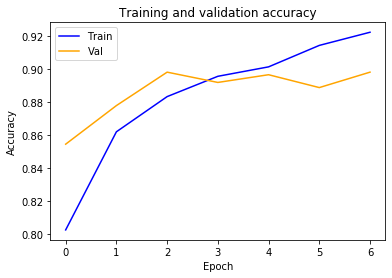

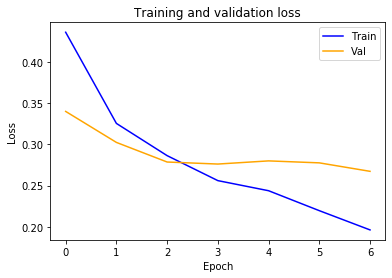

In [0]:
import matplotlib.pyplot as plt

def plot(history):
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

In [0]:
y_test_new = np.argmax(y_test, axis=1)
y_test[0:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [0]:
y_test_new[0:5]

array([0, 0, 0, 1, 0])

In [0]:
prediction = model.predict(x_test)
prediction[0:5]

array([[0.9823056 , 0.01769434],
       [0.9772356 , 0.02276444],
       [0.97641367, 0.0235863 ],
       [0.00178155, 0.9982185 ],
       [0.97545844, 0.02454151]], dtype=float32)

In [0]:
y_pred=np.argmax(prediction, axis=1)

In [0]:
np.sum(y_pred)

642

In [0]:
np.sum(y_test_new)

353

In [0]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test_new,y_pred)
print('Confusion Matrix : \n', cm1)

Confusion Matrix : 
 [[2746  330]
 [  41  312]]


In [0]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test_new, y_pred, average='macro'))
print(precision_recall_fscore_support(y_test_new, y_pred, average='weighted'))

(0.7356350747294682, 0.8882852532813668, 0.7819287465812774, None)
(0.9338873948474629, 0.8918051910177894, 0.9048513259570465, None)


In [0]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test_new, y_pred).ravel()
pre = tp / (tp + fp)
rec = tp / (tp + fn)
tnr = tn / (tn + fp)
acc = (tp + tn)/ (tp + tn + fp + fn)
balanced_acc = (rec + tnr) / 2
f1 = 2 * (pre * rec)/(pre+rec)

print(pre, rec, tnr, acc, balanced_acc, f1)

0.48598130841121495 0.8838526912181303 0.8927178153446034 0.8918051910177894 0.8882852532813668 0.6271356783919598


In [0]:
print(tp, tn, fp, fn)

312 2746 330 41


In [0]:
import math
num = (tp*tn - fp*fn)
den = math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(num, den)
mcc = num/den
print(mcc)

843222 1393851.5316603845
0.6049582619431043
